In [32]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import ast
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score, average_precision_score

In [33]:
# Step 1: Load the data
def load_data(nodes_file, train_edges_file, valid_file, test_file):
    # Load nodes and their properties
    nodes_df = pd.read_csv(nodes_file)
    train_edges_df = pd.read_csv(train_edges_file)
    valid_df = pd.read_csv(valid_file)
    test_df = pd.read_csv(test_file)
    
    return nodes_df, train_edges_df, valid_df, test_df

In [34]:
# Step 2: Process node features
def process_node_features(nodes_df):
    # One-hot encode node labels (document types)
    label_encoder = LabelEncoder()
    onehot_encoder = OneHotEncoder(sparse_output=False)  # Changed to dense output
    
    # Transform node labels
    node_labels = label_encoder.fit_transform(nodes_df['label']).reshape(-1, 1)
    node_label_features = onehot_encoder.fit_transform(node_labels)
    
    # Process text properties
    vectorizer = TfidfVectorizer(max_features=100)
    
    # Extract text from properties column
    all_texts = []
    for prop in nodes_df['properties']:
        prop = ast.literal_eval(prop)
        prop_dict = [f"{key}: {value}" for key, value in prop.items() if value]
        full_text = " | ".join(prop_dict)
        all_texts.append(full_text)
    
    # Create TF-IDF features
    text_features = vectorizer.fit_transform(all_texts)
    text_features = text_features.toarray()  # Convert sparse matrix to dense array
    
    # Combine label features and text features
    x = np.hstack([node_label_features, text_features])
    
    # Convert to PyTorch tensor
    x = torch.tensor(x, dtype=torch.float)  # Changed to float type
    
    # Keep mapping from node IDs to indices for edge creation
    node_id_to_idx = {node_id: idx for idx, node_id in enumerate(nodes_df['id'])}
    
    return x, node_id_to_idx, label_encoder

In [35]:
# Step 3: Process edges
def process_edges(edges_df, node_id_to_idx, relationship_encoder=None, fit=True):
    # Extract source and target nodes
    source_nodes = edges_df['source'].values
    target_nodes = edges_df['target'].values
    
    # Convert node IDs to indices
    edge_index = []
    for src, tgt in zip(source_nodes, target_nodes):
        if src in node_id_to_idx and tgt in node_id_to_idx:
            edge_index.append([node_id_to_idx[src], node_id_to_idx[tgt]])
    
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    
    # Process edge types if available
    edge_attr = None
    if 'relationship_type' in edges_df.columns:
        if fit:
            relationship_encoder = LabelEncoder()
            edge_types = relationship_encoder.fit_transform(edges_df['relationship_type'])
        else:
            edge_types = relationship_encoder.transform(edges_df['relationship_type'])
        
        edge_attr = torch.tensor(edge_types, dtype=torch.long)
    
    return edge_index, edge_attr, relationship_encoder


In [36]:
# Step 4: Create PyG Data object
def create_pyg_data(nodes_df, train_edges_df, valid_df, test_df):
    # Process nodes
    x, node_id_to_idx, label_encoder = process_node_features(nodes_df)
    
    # Process train edges
    train_edge_index, train_edge_attr, relationship_encoder = process_edges(train_edges_df, node_id_to_idx)
    
    # Process validation edges
    valid_edge_index, _, _ = process_edges(valid_df, node_id_to_idx, relationship_encoder, fit=False)
    
    # Process test edges
    test_edge_index, _, _ = process_edges(test_df, node_id_to_idx, relationship_encoder, fit=False)
    
    # Save node labels for evaluation (optional)
    node_labels = torch.tensor(label_encoder.transform(nodes_df['label']), dtype=torch.long)
    
    # Create Data object
    data = Data(
        x=x,
        edge_index=train_edge_index,
        edge_attr=train_edge_attr,
        y=node_labels,
        val_edge_index=valid_edge_index,
        test_edge_index=test_edge_index,
        num_nodes=len(nodes_df)
    )
    
    return data, node_id_to_idx, relationship_encoder

In [37]:
# Step 5: Generate negative samples for training
def generate_negative_samples(data, num_samples=None):
    """Generate negative edges for link prediction training"""
    from torch_geometric.utils import negative_sampling
    
    # If num_samples is None, generate same number as positive edges
    if num_samples is None:
        num_samples = data.edge_index.size(1)
    
    neg_edge_index = negative_sampling(
        edge_index=data.edge_index,
        num_nodes=data.num_nodes,
        num_neg_samples=num_samples
    )
    
    return neg_edge_index

In [38]:

# Main function to prepare the data
def prepare_pyg_data_for_link_prediction(nodes_file, train_edges_file, valid_file, test_file):
    # Load data
    nodes_df, train_edges_df, valid_df, test_df = load_data(nodes_file, train_edges_file, valid_file, test_file)
    
    # Create PyG Data object
    data, node_id_to_idx, relationship_encoder = create_pyg_data(nodes_df, train_edges_df, valid_df, test_df)
    
    # Generate negative samples
    neg_edge_index = generate_negative_samples(data)
    
    # Add negative samples to data
    data.neg_edge_index = neg_edge_index
    
    # Ensure dataset has no isolated nodes for GNN training
    check_and_fix_isolated_nodes(data)
    
    return data, node_id_to_idx, relationship_encoder

# Step 6: Check and fix isolated nodes
def check_and_fix_isolated_nodes(data):
    """
    Check for and fix isolated nodes by adding self-loops
    """
    from torch_geometric.utils import contains_isolated_nodes, add_self_loops
    
    if contains_isolated_nodes(data.edge_index, data.num_nodes):
        print("Warning: Graph contains isolated nodes. Adding self-loops...")
        # Add self-loops to ensure all nodes have at least one edge
        data.edge_index, _ = add_self_loops(data.edge_index, num_nodes=data.num_nodes)


    
  

In [39]:
def process_node_features(nodes_df):
    # One-hot encode node labels (document types)
    label_encoder = LabelEncoder()
    onehot_encoder = OneHotEncoder(sparse_output=False)  # Changed to dense output
    
    # Transform node labels
    node_labels = label_encoder.fit_transform(nodes_df['label']).reshape(-1, 1)
    node_label_features = onehot_encoder.fit_transform(node_labels)
    
    # Process text properties
    vectorizer = TfidfVectorizer(max_features=100)
    
    # Extract text from properties column
    all_texts = []
    for prop in nodes_df['properties']:
        prop = ast.literal_eval(prop)
        prop_dict = [f"{key}: {value}" for key, value in prop.items() if value]
        full_text = " | ".join(prop_dict)
        all_texts.append(full_text)
    
    # Create TF-IDF features
    text_features = vectorizer.fit_transform(all_texts)
    text_features = text_features.toarray()  # Convert sparse matrix to dense array
    
    # Combine label features and text features
    x = np.hstack([node_label_features, text_features])
    
    # Convert to PyTorch tensor
    x = torch.tensor(x, dtype=torch.float)  # Changed to float type
    
    # Keep mapping from node IDs to indices for edge creation
    node_id_to_idx = {node_id: idx for idx, node_id in enumerate(nodes_df['id'])}
    
    return x, node_id_to_idx, label_encoder

#Process and create the Dataset


In [40]:
nodes_file = "Dataset/nodes.csv"
train_edges_file = "Dataset/train_edges.csv"
valid_file = "Dataset/val_links.csv"
test_file = "Dataset/test_links.csv"

data, node_id_to_idx, relationship_encoder = prepare_pyg_data_for_link_prediction(nodes_file, train_edges_file, valid_file, test_file)
print(data)
#  to keep track of the mapping
relationship_mapping = dict(enumerate(relationship_encoder.classes_))
print("Relationship Mapping:", relationship_mapping)

Data(x=[5763, 107], edge_index=[2, 13820], edge_attr=[13820], y=[5763], val_edge_index=[2, 860], test_edge_index=[2, 860], num_nodes=5763, neg_edge_index=[2, 13820])
Relationship Mapping: {0: 'HAS_DATASET', 1: 'HAS_INSTRUMENT', 2: 'HAS_PLATFORM', 3: 'HAS_SCIENCEKEYWORD', 4: 'OF_PROJECT', 5: 'SUBCATEGORY_OF', 6: 'USES_DATASET'}


In [41]:
# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Number of nodes: 5763
Number of edges: 13820
Average node degree: 2.40
Has isolated nodes: False
Has self-loops: False
Is undirected: False


In [42]:
# Node Feature Statistics
node_features = data.x.numpy()
print("\nNode Feature Statistics:")
print(f"Feature dimension: {node_features.shape[1]}")
print(f"Mean: {np.mean(node_features):.4f}")
print(f"Std: {np.std(node_features):.4f}")
print(f"Min: {np.min(node_features):.4f}")
print(f"Max: {np.max(node_features):.4f}")


Node Feature Statistics:
Feature dimension: 107
Mean: 0.0367
Std: 0.1317
Min: 0.0000
Max: 1.0000


In [43]:
G = nx.Graph()
G.add_edges_from(data.edge_index.t().numpy())

# 1. Node Degree Distribution
degrees = [d for n, d in G.degree()]
degree_dist = Counter(degrees)

print("\nDegree Statistics:")
print(f"Average degree: {np.mean(degrees):.2f}")
print(f"Max degree: {max(degrees)}")
print(f"Min degree: {min(degrees)}")
#Graph Density
density = nx.density(G)
print(f"\nGraph Density: {density:.4f}")


Degree Statistics:
Average degree: 4.80
Max degree: 1300
Min degree: 1

Graph Density: 0.0008


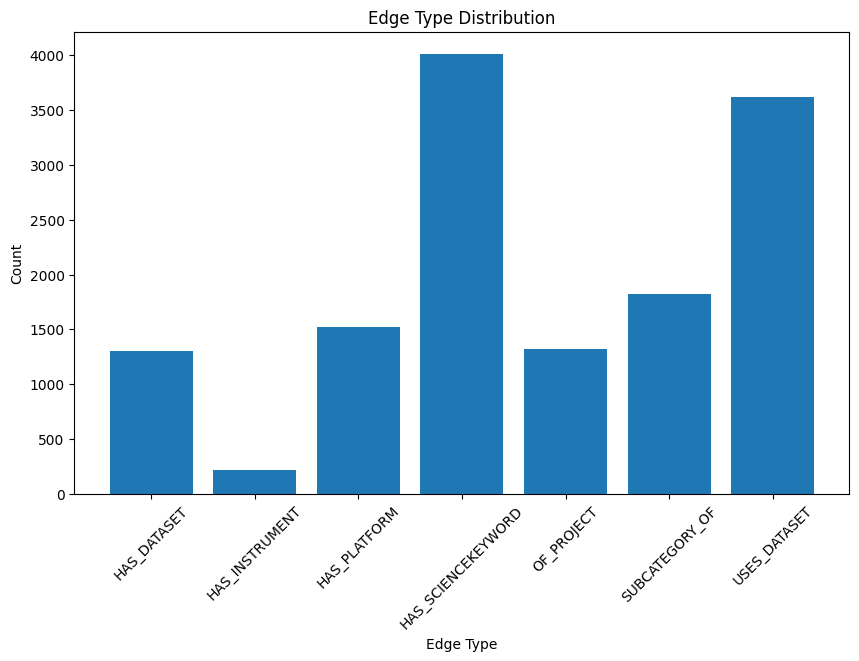


Edge Type Distribution:
OF_PROJECT: 1325 edges
HAS_DATASET: 1300 edges
HAS_SCIENCEKEYWORD: 4015 edges
USES_DATASET: 3623 edges
HAS_PLATFORM: 1519 edges
SUBCATEGORY_OF: 1823 edges
HAS_INSTRUMENT: 215 edges


In [44]:
edge_types = data.edge_attr.numpy()
edge_type_dist = Counter(edge_types)

plt.figure(figsize=(10, 6))
plt.bar(edge_type_dist.keys(), edge_type_dist.values())
plt.title('Edge Type Distribution')
plt.xlabel('Edge Type')
plt.ylabel('Count')
plt.xticks(range(len(relationship_mapping)), list(relationship_mapping.values()), rotation=45)
plt.show()

print("\nEdge Type Distribution:")
for edge_type, count in edge_type_dist.items():
    print(f"{relationship_mapping[edge_type]}: {count} edges")

### GCN Embedding generation and LInkprediction class

In [45]:
class GCNLinkPrediction(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=2, dropout=0.5):
        super(GCNLinkPrediction, self).__init__()
        
        # Store dimensions
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.num_layers = num_layers
        self.dropout = dropout
        
        # Create list of GCN layers
        self.convs = nn.ModuleList()
        
        # First layer maps from input features to hidden features
        self.convs.append(GCNConv(in_channels, hidden_channels))
        
        # Middle layers (if any)
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
        
        # Last layer maps to output embedding dimensions
        self.convs.append(GCNConv(hidden_channels, out_channels))
        
        # Link prediction scoring function (inner product)
        self.link_predictor = LinkPredictor(out_channels)
        
    def encode(self, x, edge_index):
        """Generate node embeddings"""
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Last layer (no ReLU to allow negative values in embeddings)
        x = self.convs[-1](x, edge_index)
        return x
    
    def decode(self, z, edge_index):
        """Predict link scores from embeddings"""
        return self.link_predictor(z, edge_index)
    
    def forward(self, x, edge_index, edge_label_index=None):
        """Forward pass: Generate embeddings and predict links"""
        # Generate node embeddings
        z = self.encode(x, edge_index)
        
        # If edge_label_index is provided, predict those links
        # Otherwise predict the links in edge_index
        edge_index_to_predict = edge_label_index if edge_label_index is not None else edge_index
        
        # Predict links
        return self.decode(z, edge_index_to_predict), z
    
class LinkPredictor(torch.nn.Module):
    """Link prediction layer that computes edge scores"""
    def __init__(self, embedding_dim, hidden_dim=None):
        super(LinkPredictor, self).__init__()
        if hidden_dim is not None:
            # MLP version for more complex link prediction
            self.lin1 = nn.Linear(embedding_dim * 2, hidden_dim)
            self.lin2 = nn.Linear(hidden_dim, 1)
            self.use_mlp = True
        else:
            # Simple dot product version
            self.use_mlp = False
    
    def forward(self, z, edge_index):
        # Extract node embeddings for each edge
        src, dst = edge_index
        
        if self.use_mlp:
            # Concatenate source and destination embeddings
            edge_features = torch.cat([z[src], z[dst]], dim=1)
            # Apply MLP
            x = self.lin1(edge_features)
            x = F.relu(x)
            x = self.lin2(x)
            return torch.sigmoid(x).squeeze()
        else:
            # Simple dot product scoring
            # Compute similarity between source and destination embeddings
            return torch.sum(z[src] * z[dst], dim=1)

## Training Function

In [46]:
def train_link_prediction(model, data, optimizer, batch_size=1024):
    model.train()
    
    # Get total number of edges
    total_edges = data.edge_index.size(1)
    
    # Process in batches for memory efficiency
    total_loss = 0
    
    for batch_start in range(0, total_edges, batch_size):
        # Get batch of positive edges
        batch_end = min(batch_start + batch_size, total_edges)
        edge_id = torch.arange(batch_start, batch_end)
        
        # Generate negative edges for this batch
        neg_edge_index = negative_sampling(
            edge_index=data.edge_index,
            num_nodes=data.num_nodes,
            num_neg_samples=batch_end - batch_start
        )
        
        # Create labels: 1 for positive edges, 0 for negative edges
        pos_labels = torch.ones(batch_end - batch_start, device=data.edge_index.device)
        neg_labels = torch.zeros(batch_end - batch_start, device=data.edge_index.device)
        labels = torch.cat([pos_labels, neg_labels])
        
        # Get predictions for both positive and negative edges
        pos_edge = data.edge_index[:, edge_id]
        edge_index_pred = torch.cat([pos_edge, neg_edge_index], dim=1)
        
        # Forward pass
        optimizer.zero_grad()
        pred, _ = model(data.x, data.edge_index, edge_index_pred)
        
        # Calculate loss
        loss = F.binary_cross_entropy_with_logits(pred, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss

### Evaluation Function

In [47]:


# Evaluation function
@torch.no_grad()
def test_link_prediction(model, data, pos_edge_index, neg_edge_index=None):
    model.eval()
    
    # Get embeddings
    z = model.encode(data.x, data.edge_index)
    
    # Evaluate on positive edges
    pos_pred = model.decode(z, pos_edge_index)
    
    # If negative edges are not provided, generate them
    if neg_edge_index is None:
        neg_edge_index = negative_sampling(
            edge_index=data.edge_index,
            num_nodes=data.num_nodes,
            num_neg_samples=pos_edge_index.size(1)
        )
    
    # Evaluate on negative edges
    neg_pred = model.decode(z, neg_edge_index)
    
    # Create labels: 1 for positive edges, 0 for negative edges
    pos_labels = torch.ones(pos_pred.size(0), device=pos_pred.device)
    neg_labels = torch.zeros(neg_pred.size(0), device=neg_pred.device)
    
    # Concatenate predictions and labels
    pred = torch.cat([pos_pred, neg_pred])
    labels = torch.cat([pos_labels, neg_labels])
    
    # Calculate metrics
    pred_np = pred.cpu().numpy()
    labels_np = labels.cpu().numpy()
    
    auc = roc_auc_score(labels_np, pred_np)
    ap = average_precision_score(labels_np, pred_np)
    
    return auc, ap





### Call Train and Evaluation functions

In [48]:


def train_and_evaluate_model(data, in_channels, epochs=100):
    # Define model parameters
    hidden_channels = 64
    out_channels = 32  # Final embedding dimension
    
    # Create model
    model = GCNLinkPrediction(
        in_channels=in_channels, 
        hidden_channels=hidden_channels,
        out_channels=out_channels,
        num_layers=2,
        dropout=0.5
    )
    
    # Define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    
    # Training loop
    best_val_auc = 0
    for epoch in range(1, epochs + 1):
        # Train
        loss = train_link_prediction(model, data, optimizer)
        
        # Evaluate
        val_auc, val_ap = test_link_prediction(model, data, data.val_edge_index)
        
        # Track best model
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            torch.save(model.state_dict(), 'best_gcn_model.pt')
        
        # Print progress
        if epoch % 10 == 0:
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val AUC: {val_auc:.4f}, Val AP: {val_ap:.4f}')
    
    # Load best model
    model.load_state_dict(torch.load('best_gcn_model.pt'))
    
    # Evaluate on test set
    test_auc, test_ap = test_link_prediction(model, data, data.test_edge_index)
    print(f'Final Test AUC: {test_auc:.4f}, Test AP: {test_ap:.4f}')
    
    return model


Train and Evaluate

In [49]:

# Move data to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

# Train model
in_channels = data.x.size(1)  # Number of input features
model = train_and_evaluate_model(data, in_channels, epochs=100)

# Get node embeddings
with torch.no_grad():
    node_embeddings = model.encode(data.x, data.edge_index).cpu().numpy()

# Save embeddings for further analysis
import numpy as np
np.save('node_embeddings.npy', node_embeddings)

print(f"Embeddings shape: {node_embeddings.shape}")
print("Node embeddings saved to 'node_embeddings.npy'")


Epoch: 010, Loss: 6.4998, Val AUC: 0.9878, Val AP: 0.9902
Epoch: 020, Loss: 6.4195, Val AUC: 0.9950, Val AP: 0.9903
Epoch: 030, Loss: 6.5123, Val AUC: 0.9917, Val AP: 0.9937
Epoch: 040, Loss: 6.3273, Val AUC: 0.9940, Val AP: 0.9950
Epoch: 050, Loss: 6.4823, Val AUC: 0.9935, Val AP: 0.9935
Epoch: 060, Loss: 6.5014, Val AUC: 0.9956, Val AP: 0.9951
Epoch: 070, Loss: 6.3431, Val AUC: 0.9895, Val AP: 0.9915
Epoch: 080, Loss: 6.4590, Val AUC: 0.9975, Val AP: 0.9981
Epoch: 090, Loss: 6.4682, Val AUC: 0.9912, Val AP: 0.9926
Epoch: 100, Loss: 6.4769, Val AUC: 0.9862, Val AP: 0.9846
Final Test AUC: 0.9958, Test AP: 0.9956
Embeddings shape: (5763, 32)
Node embeddings saved to 'node_embeddings.npy'
